In [1]:
### LSTM model

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima


df=pd.read_csv("^NDX.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

#df['Return']= np.log1p(df.Close.pct_change())
#df.head(5)

Number of rows and columns: (5031, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,2341.280029,2347.699951,2105.489990,2128.780029,2128.780029,1918930000
1,2001-01-03,2087.320068,2530.530029,2087.320068,2528.379883,2528.379883,3188000000
2,2001-01-04,2485.520020,2547.040039,2432.040039,2460.040039,2460.040039,2610680000
3,2001-01-05,2460.810059,2463.479980,2252.360107,2267.850098,2267.850098,2104670000
4,2001-01-08,2245.439941,2282.949951,2151.159912,2281.540039,2281.540039,1850590000


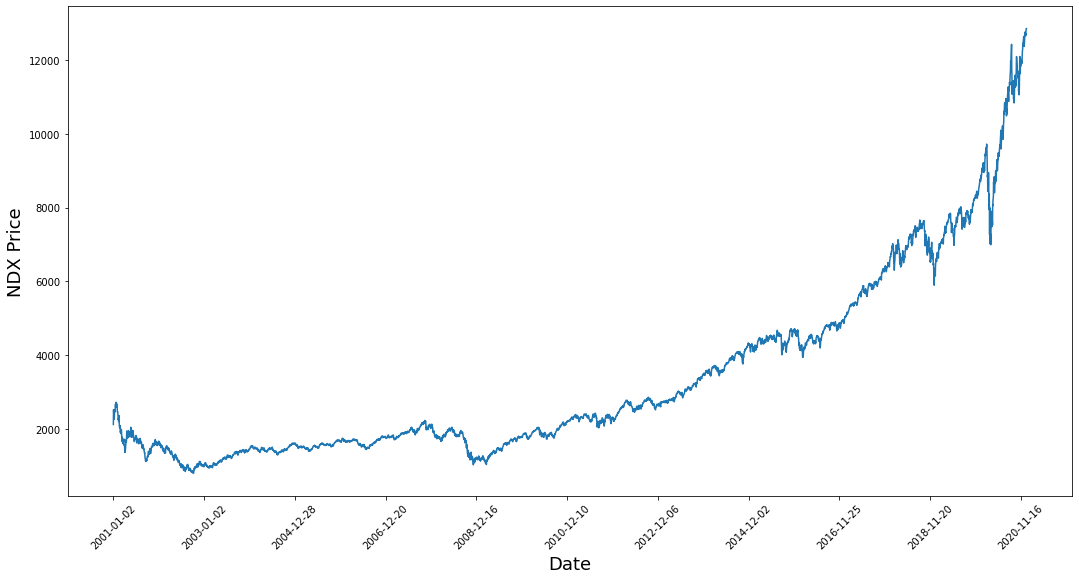

In [3]:
plt.figure(figsize = (18,9))
plt.plot(df['Close'])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('NDX Price',fontsize=18)
plt.show()

In [4]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

In [5]:
training_set = df.iloc[:3000, 4:5].values
test_set = df.iloc[3000:, 4:5].values

In [6]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 100 time-steps and 1 output
X_train = []
y_train = []
for i in range(100, 3000):
    X_train.append(training_set_scaled[i-100:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
(2900, 100, 1)

(2900, 100, 1)

In [7]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
91/91 [==============================] - 13s 147ms/step - loss: 0.0152
Epoch 2/50
91/91 [==============================] - 14s 149ms/step - loss: 0.0043
Epoch 3/50
91/91 [==============================] - 14s 151ms/step - loss: 0.0039
Epoch 4/50
91/91 [==============================] - 14s 151ms/step - loss: 0.0032
Epoch 5/50
91/91 [==============================] - 14s 150ms/step - loss: 0.0030
Epoch 6/50
91/91 [==============================] - 14s 150ms/step - loss: 0.0031
Epoch 7/50
91/91 [==============================] - 14s 150ms/step - loss: 0.0026
Epoch 8/50
91/91 [==============================] - 14s 151ms/step - loss: 0.0024
Epoch 9/50
91/91 [==============================] - 14s 151ms/step - loss: 0.0024
Epoch 10/50
91/91 [==============================] - 14s 151ms/step - loss: 0.0025
Epoch 11/50
91/91 [==============================] - 14s 150ms/step - loss: 0.0022
Epoch 12/50
91/91 [==============================] - 14s 151ms/step - loss: 0.0019
Epoch 13/50
9

In [8]:
# Getting the predicted stock price 
dataset_train = df.iloc[:3000, 1:2]
dataset_test = df.iloc[3000:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 100:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(100, 2131):
    X_test.append(inputs[i-100:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (2031, 100, 1)

(2031, 100, 1)


In [9]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

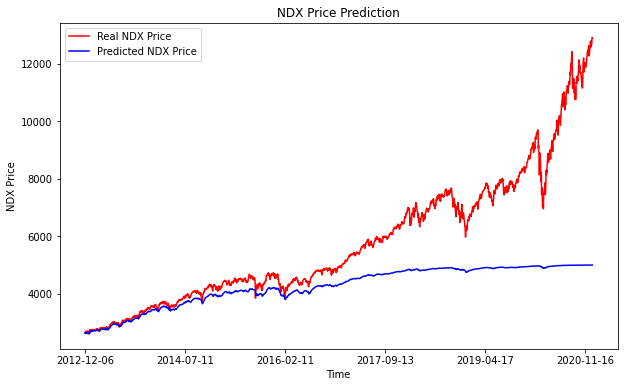

In [10]:
# Visualising the results
plt.plot(df.loc[3000:, 'Date'],dataset_test.values, color = 'red', label = 'Real NDX Price')
plt.plot(df.loc[3000:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted NDX Price')
plt.xticks(np.arange(0,2031,400))
plt.title('NDX Price Prediction')
plt.xlabel('Time')
plt.ylabel('NDX Price')
plt.legend()
plt.show()

In [11]:
# report performance
mse = mean_squared_error(test_set, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_set, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predicted_stock_price - test_set)/np.abs(test_set))
print('MAPE: '+str(mape))

MSE: 5507023.99592905
MAE: 1534.520427396018
RMSE: 2346.704923063198
MAPE: 0.1994425272823201


In [12]:
### ARIMA Model

<ipython-input-13-bc8f97ed08f9>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df['Close'], model='multiplicative', freq = 30)


<Figure size 720x432 with 0 Axes>

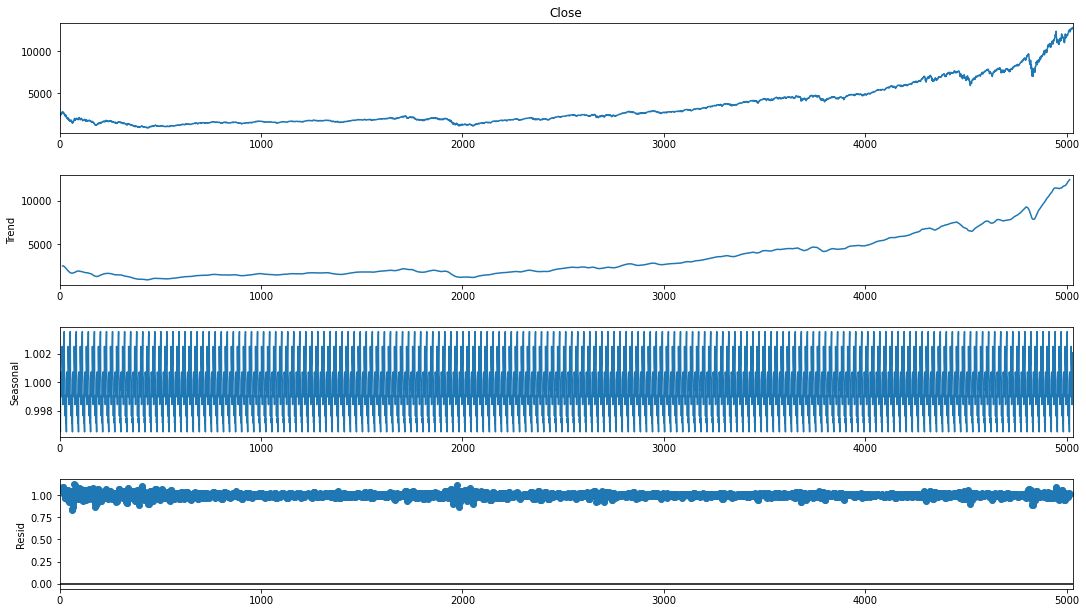

In [13]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


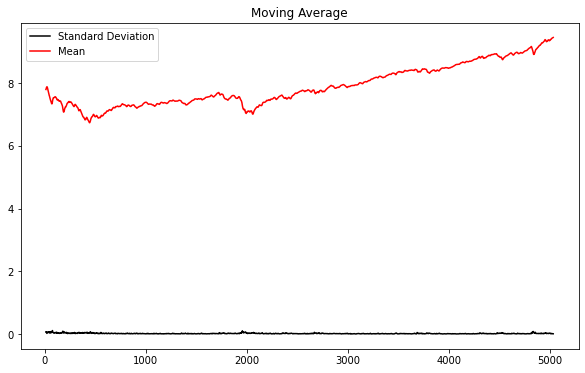

In [14]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

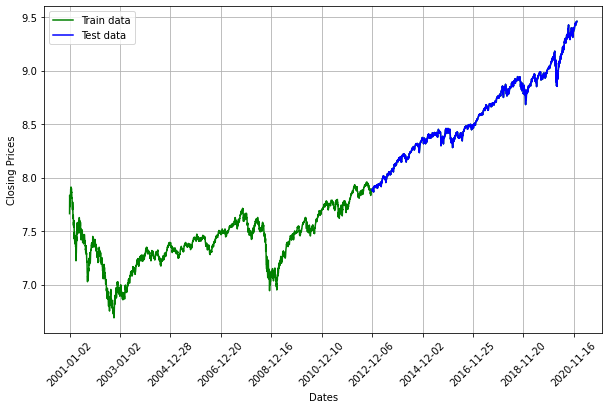

In [15]:
## split data into train and training set
train_data, test_data = df_log[1:int(3000)], df_log[-int(2031):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20540.030, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-15497.997, Time=0.98 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.63 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-15508.832, Time=1.38 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.57 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-15495.372, Time=1.56 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=8775.461, Time=0.61 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-15485.829, Time=2.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-15517.487, Time=0.95 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-6416.087, Time=1.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-15505.115, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1

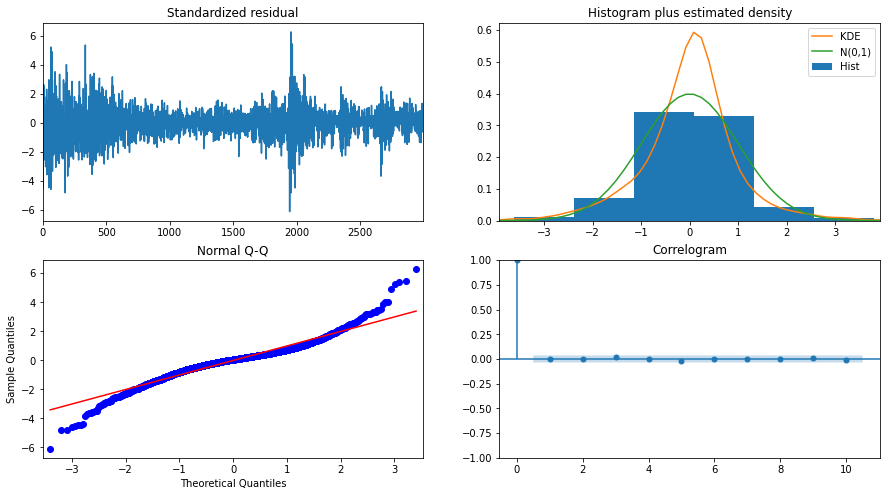

In [16]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [17]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,0,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2998
Model:                 ARIMA(1, 1, 2)   Log Likelihood                7763.489
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sat, 11 Dec 2021   AIC                         -15516.978
Time:                        22:23:25   BIC                         -15486.950
Sample:                             1   HQIC                        -15506.177
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.723e-05      0.000      0.058      0.954      -0.001       0.001
ar.L1.D.Close    -0.2290      0.199     -1.150      0.250      -0.619       0.161
ma.L1.D.Close     0.1821      0.198     

In [18]:
# Forecast
fc, se, conf = fitted.forecast(2031, alpha=0.05)  # 95% conf

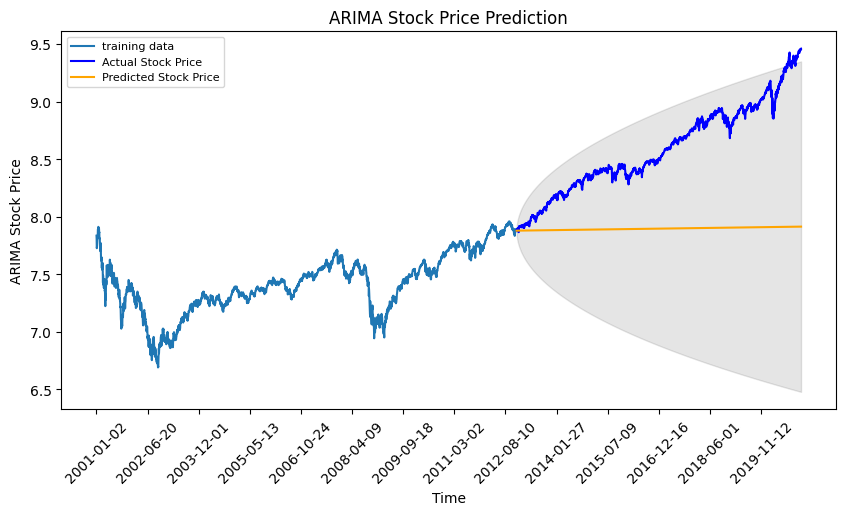

In [19]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)

plt.title('ARIMA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARIMA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(range(0,df.shape[0],365),df['Date'].loc[::365],rotation=45)
plt.show()

In [20]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.6200018563444487
MAE: 0.6933462553632771
RMSE: 0.7874019661802024
MAPE: 0.0789478739064807
